### Import libraries

In [26]:
#import libraries
import gdal
import random
from random import sample
import rasterio
import geopandas as gpd
from osgeo import gdal, gdal_array
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rasterio.mask import mask
import earthpy.plot as ep
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from matplotlib.colors import ListedColormap, BoundaryNorm

In [27]:
# normalized raster datasets

red = 'C:/Normalized/Red_bands_Normalized.tif'
green = 'C:/Normalized/Green_bands_Normalized.tif'
blue = 'C:/Normalized/Blue_bands_Normalized.tif'
nir = 'C:/Normalized/NIR_bands_Normalized.tif'
ndvi ='C:/Normalized/NDVI_Normalized.tif'
evi = 'C:/Normalized/EVI_Normalized.tif'
savi ='C:/Normalized/SAVI_Normalized.tif'


### Split train and test data ground truth

In [28]:
#read the training data
#read shapefile to geopandas geodataframe
GT_data = gpd.read_file("D://CDE//Internship_INRAE//Data_Dordogne//DORDOGNE_GT_SAMPLES.shp")
#get names of the land cover classes
classes_names = GT_data['Land Cover'].unique()
#split the the ground truth data into training and test sets and save it to a new shapefile
train = GT_data.sample(frac = 0.4)
test = GT_data.drop(train.index)
train.to_file('D://CDE//Internship_INRAE//Data_Dordogne//training_data_pixel_based//train_data_40.shp')
test.to_file('D://CDE//Internship_INRAE//Data_Dordogne//training_data_pixel_based//test_data_60.shp')

### Distribution of train and test data

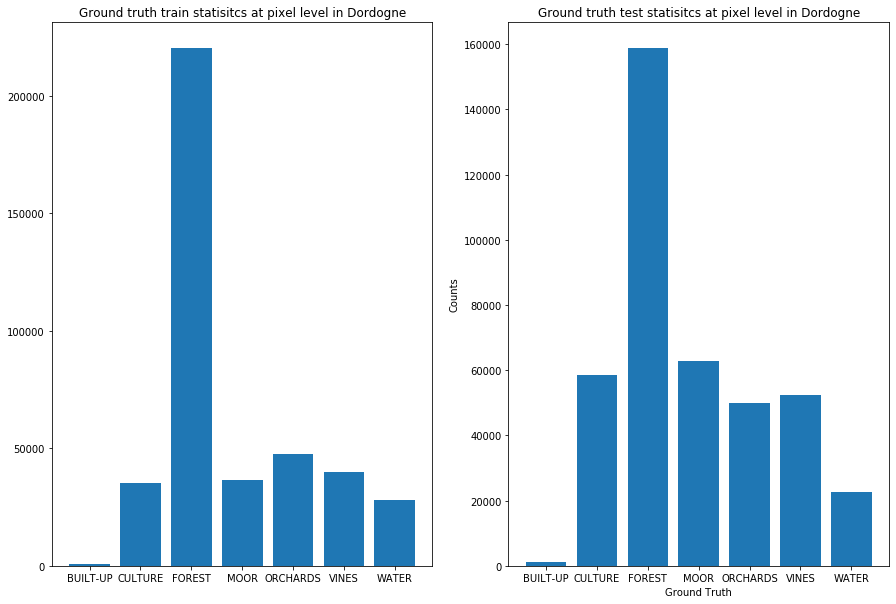

In [29]:
#pixel_level= stat.groupby(['Land Cover']).sum()
#pixel_level
#pixel_level.to_csv('D://CDE//Internship_INRAE//Data_Dordogne//DORDOGNE_GT_SAMPLES_stats.csv', encoding='utf-8')
train_samples=pd.read_csv('D://CDE//Internship_INRAE//Data_Dordogne//train_40_stats.csv')
test_samples=pd.read_csv('D://CDE//Internship_INRAE//Data_Dordogne//test_60_stats.csv')
#plot dstribution
#fig, (ax1, ax2) = plt.subplot(1, 2)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,10))
#plt.subplots(1,2,figsize=(16,10))
ax2.set_title('Ground truth test statisitcs at pixel level in Dordogne')
ax1.bar(train_samples['Land Cover'],train_samples['count'])
ax1.set_title('Ground truth train statisitcs at pixel level in Dordogne')
plt.xlabel('Ground Truth')
plt.ylabel('Counts')
ax2.bar(test_samples['Land Cover'],test_samples['count'])
plt.show()

In [30]:
# Import NumPy for some statistics
import numpy as np

roi_ds = gdal.Open('D://CDE//Internship_INRAE//Data_Dordogne//training_data_pixel_based//train_data_40.tif', gdal.GA_ReadOnly)

roi = roi_ds.GetRasterBand(1).ReadAsArray()

# How many pixels are in each class?
classes = np.unique(roi)
# Iterate over all class labels in the ROI image, printing out some information
for c in classes:
    print('Class {c} contains {n} pixels'.format(c=c,
                                                 n=(roi == c).sum()))

Class 0.0 contains 29668929 pixels
Class 1.0 contains 843 pixels
Class 2.0 contains 28518 pixels
Class 3.0 contains 187953 pixels
Class 4.0 contains 40824 pixels
Class 5.0 contains 28450 pixels
Class 6.0 contains 40442 pixels
Class 7.0 contains 37121 pixels


### Train data preparation

In [31]:
lst = [blue,green,red,nir,ndvi,savi,evi]
path_to_roi = 'D://CDE//Internship_INRAE//Data_Dordogne//training_data_pixel_based//train_data_40.tif'

with rasterio.open(path_to_roi) as ds:
    roi_array = ds.read(1)
    nodata = ds.profile['nodata']

idx = np.where(roi_array!=nodata)

train_X = []
for band in lst:
    with rasterio.open(band) as ds:
        band_array = ds.read()
        #print (band_array.shape)
        band_array = np.moveaxis(band_array,0,-1)
        #print (band_array.shape)
        band_array_roi = band_array[idx]
        #print (band_array_roi.shape)
        train_X.append( band_array_roi )
train_X = np.column_stack(train_X)
print (train_X.shape)

(364151, 56)


In [9]:
y = roi_array[roi_array > 0]
y.shape

(364151,)

In [32]:
X = train_X 
y

array([7., 3., 3., ..., 5., 5., 5.], dtype=float32)

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    train_X, y, test_size=0.85, random_state=42,stratify = y)

In [34]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(54622, 56)
(309529, 56)
(54622,)
(309529,)


### Random Forest Classifier

In [35]:
classifier= RandomForestClassifier(n_estimators = 400,min_samples_split = 4)
classifier.fit(X_train,y_train)
result_valid = classifier.predict(X_test)
print('done')

done


### Classification Accuracy

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score

print('Overal Accuracy TA : ', accuracy_score(result_valid, y_test))
print('Cohen_kappa TA: ', cohen_kappa_score(result_valid, y_test))
print ('F1 score:', f1_score(y_test, result_valid,average=None))
print ('F1 score:', f1_score(y_test, result_valid,average= 'weighted'))

Overal Accuracy TA :  0.9020027202620756
Cohen_kappa TA:  0.8533742333249361
F1 score: [0.18 0.98 0.94 0.65 0.88 0.92 0.9 ]
F1 score: 0.8954219890943088


### Feature Importances

[0.00798613 0.01514628 0.01856032 0.01860831 0.01021478 0.00931803
 0.00876156 0.00977706 0.01421795 0.04507497 0.02813787 0.01584701
 0.01185003 0.00795196 0.00922623 0.01707634 0.0112491  0.01874249
 0.02484707 0.03480664 0.00986047 0.00778143 0.00649716 0.00726979
 0.06676498 0.03685107 0.02721697 0.02123057 0.02161151 0.01888462
 0.01337904 0.01418366 0.0183718  0.01213688 0.02733098 0.04637367
 0.0094457  0.01283014 0.00845742 0.00684847 0.01800458 0.01198322
 0.022556   0.04548468 0.0097055  0.01211304 0.00757947 0.00684965
 0.02196792 0.01484484 0.01502511 0.04646042 0.01136293 0.01096448
 0.00653153 0.00784017]


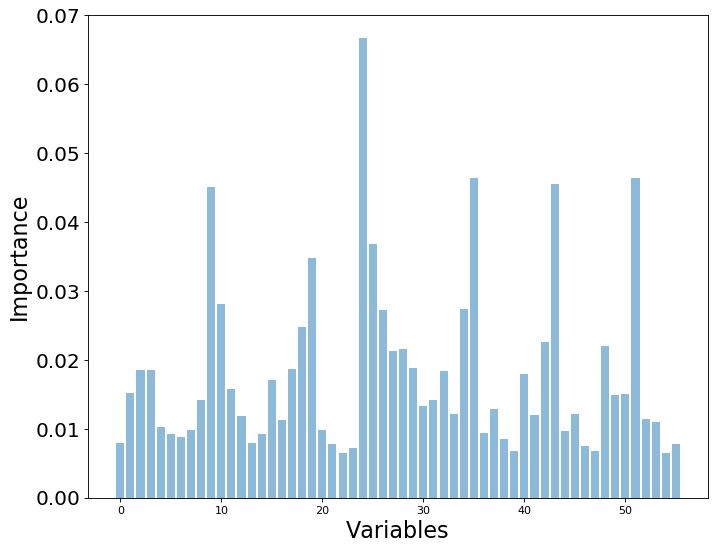

In [15]:
importance = classifier.feature_importances_
print(importance)
y_pos = np.arange(len(importance))
plt.figure(figsize = (10,8), dpi=80)
plt.bar(y_pos,importance,align ='center',alpha=0.5)
#plt.xticks(y_pos,list_label_raster, fontsize=18, rotation=90)
plt.yticks(fontsize=18)
plt.ylabel("Importance", fontsize=20)
plt.xlabel('Variables',fontsize=20)
plt.savefig('RF_importance.png', bbox_inches="tight")

### Confusion matrix

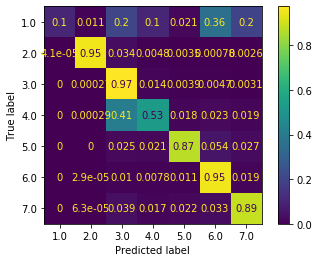

<Figure size 1440x1296 with 0 Axes>

In [17]:
np.set_printoptions(precision=2)
plot_confusion_matrix(classifier,X_test,y_test,labels = np.unique(y_test),normalize= 'true')

plt.figure(figsize = (20,18))
#plot_confusion_matrix(cm, labels=np.unique(y_test), normalize=True)
plt.savefig('confusionmatrix.png', bbox_inches="tight")
plt.show()

In [97]:
raster_blue=rasterio.open(blue)
raster_blue =raster_blue.read(1)
raster_blue.shape

(5390, 5572)

### Predict for the whole image

In [16]:
# whole image
band_lst = [blue,green,red,nir,ndvi,savi,evi]
img = []
for band in band_lst:
    with rasterio.open(band) as ds:
        band_array = ds.read()
        print(band_array.shape)
        band_array = np.moveaxis(band_array,0,-1)
        img.append( band_array )
         
#img = np.stack(img,axis=2)
img_shp = np.concatenate(img,axis= 2)
print (img_shp.shape)
img = img_shp.reshape(-1, img_shp.shape[2] )
#img = np.column_stack(img)
print (img.shape)

(8, 5390, 5572)
(8, 5390, 5572)
(8, 5390, 5572)
(8, 5390, 5572)
(8, 5390, 5572)
(8, 5390, 5572)
(8, 5390, 5572)
(5390, 5572, 56)
(30033080, 56)


In [19]:
img.shape

(30033080, 56)

In [21]:
class_prediction_rf = classifier.predict(img)

In [103]:
# Predict for each pixel

#class_prediction = classifier.predict(img)

In [22]:
class_prediction_rf.shape

(30033080,)

I am unable to reshape the classified results so as visualize as a map as shown below

In [41]:
# Reshape the classification map
class_prediction = class_prediction_rf.reshape(img_shp.shape[0] ,img_shp.shape[1] )
class_prediction.shape

(5390, 5572)

### Visualize classified map

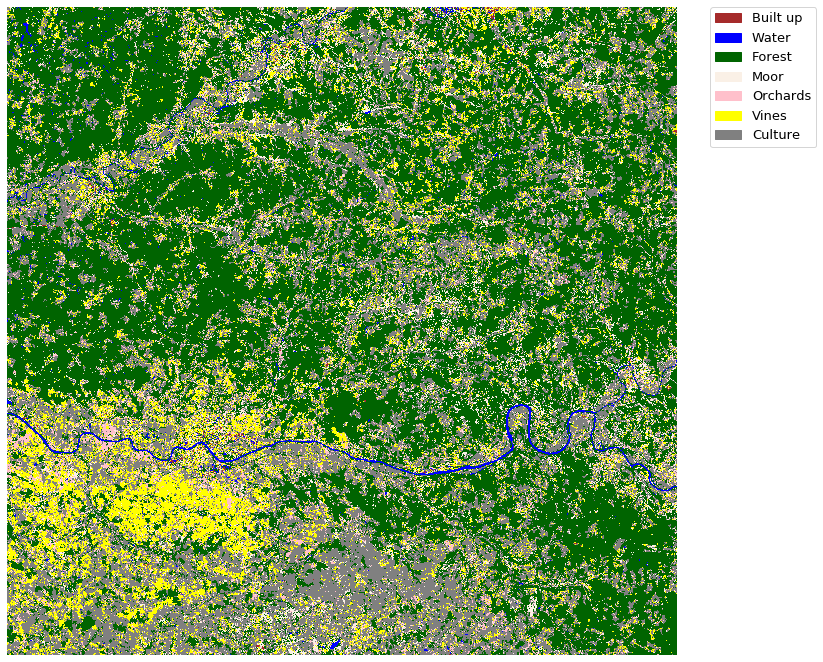

In [42]:
# Create a list of labels to use for your legend
height_class_labels = ["Built up", "Water",
                       "Forest", "Moor",
                      "Orchards","Vines","Culture"]

# Create a colormap from a list of colors
colors = ['grey','blue','darkgreen', 'lightgreen', 'linen','pink', 'yellow','brown']
cmap = ListedColormap(colors)

f, ax = plt.subplots(figsize=(12, 12))

im = ax.imshow(class_prediction,
               cmap=cmap)

ep.draw_legend(im, titles=height_class_labels)
ax.set_axis_off()

plt.show()

### Write out the results

In [47]:

red_r = 'D:/CDE/Internship_INRAE/Sentinel_2_Data/Gap_Filled/ImageTimeSeriesGapFilling_B4_DORDOGNE_2016_CONCAT_S2.tif'
    
with rasterio.open(red_r) as src:

    # Write an array as a raster band to a new  file. For
    # the new file's profile, we start with the profile of the source
    profile = src.profile

    # And then change the band count to 1, set the
    # dtype to float32, and specify LZW compression.
    profile.update(
        dtype=rasterio.float32,
        count=1,
        compress='lzw')

    with rasterio.open('D:/CDE/Internship_INRAE/RandomForestClassification/Pixel_Based_Classification_RF_Dordogne.tif', 'w', **profile) as dst:
        dst.write(class_prediction.astype(rasterio.float32), 1)

